<a href="https://colab.research.google.com/github/sawandarekar/era_v3_assignment_7/blob/main/era_v3_assignment_7_model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Target:
- Reduce parameters bellow 10k count
- Make sure, defined model get trained, also add GAP, MaxPool,
- Achive test accuracy > 99.41%
- Limit the 10 epoch

## Result:
- Parameters:
- Best Training Accuracy:
- Best Test Accuracy:

## Analysis:
- model trained with 12k parameters
- Added Batch Normalization, MaxPool2d and dropout = 0.1
- Model is Over fitting from 14th epoch (training accuracy: 99.10% test accuracy: 98.93%)

In [17]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [18]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [19]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [20]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


## **Data Loader Details**

In [21]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

#plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


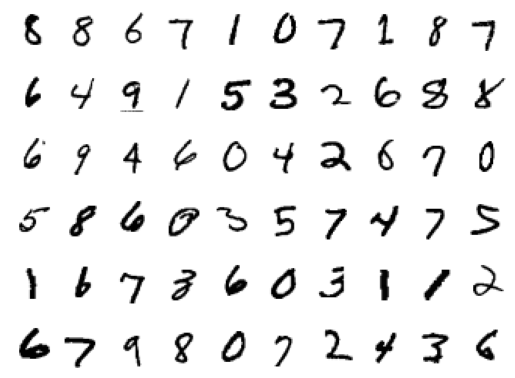

In [22]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Find mean and std values

In [23]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


## Model Defination

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        drop_out_value = 0.1

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),# affine=False),
            nn.Dropout(drop_out_value)
        ) # output_size = 26*26   RF=3*3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),# affine=False),
            nn.Dropout(drop_out_value)
        ) # output_size = 24*24  RF=5*5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),# affine=False),
            nn.Dropout(drop_out_value)
        ) # output_size = 22*22   RF=7*7

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output_size = 11*11  RF=14*14

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),# affine=False),
            nn.Dropout(drop_out_value)
        ) # output_size = 9*9   RF=16*16

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),# affine=False),
            nn.Dropout(drop_out_value)
        ) # output_size = 7*7.  RF=18*18


        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 5*5.  RF=

        self.gap = nn.AvgPool2d(5)

        self.skip1 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(1, 1), padding=0, bias=False)
        self.skip2 = nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(1, 1), padding=0, bias=False)



    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock7(x)
        x = self.convblock8(x)

        x = self.gap(x)

        x = x.view(-1, 10)

        return F.log_softmax(x, dim=-1)



## Model Parameters Deatils

In [25]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Defaulting to user installation because normal site-packages is not writeable
cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,728
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 12, 22, 22]           1,728
             ReLU-10           [-1, 12, 22, 22]               0
      BatchNorm2d-11           [-1, 12, 22, 22]              24
          Dropout-12           [-1, 12, 22, 22]               0
        MaxPool2d-13 

## Training valiating

In [26]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'EPOCH:{epoch} Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

## Training and testing model for each EPOCH

In [27]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH:0 Loss=0.02191450260579586 Batch_id=937 Accuracy=93.67: 100%|██████████| 938/938 [01:06<00:00, 14.11it/s] 



Test set: Average loss: 0.0797, Accuracy: 9749/10000 (97.49%)



EPOCH:1 Loss=0.17861826717853546 Batch_id=937 Accuracy=98.03: 100%|██████████| 938/938 [00:59<00:00, 15.86it/s]  



Test set: Average loss: 0.0465, Accuracy: 9860/10000 (98.60%)



EPOCH:2 Loss=0.06590324640274048 Batch_id=937 Accuracy=98.43: 100%|██████████| 938/938 [01:03<00:00, 14.84it/s]  



Test set: Average loss: 0.0384, Accuracy: 9878/10000 (98.78%)



EPOCH:3 Loss=0.06832192093133926 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [01:11<00:00, 13.19it/s]  



Test set: Average loss: 0.0365, Accuracy: 9883/10000 (98.83%)



EPOCH:4 Loss=0.003093623323366046 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [01:04<00:00, 14.58it/s] 



Test set: Average loss: 0.0365, Accuracy: 9885/10000 (98.85%)



EPOCH:5 Loss=0.018334288150072098 Batch_id=937 Accuracy=98.87: 100%|██████████| 938/938 [01:01<00:00, 15.24it/s] 



Test set: Average loss: 0.0315, Accuracy: 9905/10000 (99.05%)



EPOCH:6 Loss=0.08595608919858932 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [01:03<00:00, 14.72it/s]  



Test set: Average loss: 0.0354, Accuracy: 9896/10000 (98.96%)



EPOCH:7 Loss=0.006261872593313456 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [01:03<00:00, 14.85it/s] 



Test set: Average loss: 0.0323, Accuracy: 9904/10000 (99.04%)



EPOCH:8 Loss=0.04650861397385597 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [01:16<00:00, 12.20it/s]  



Test set: Average loss: 0.0290, Accuracy: 9908/10000 (99.08%)



EPOCH:9 Loss=0.00402163527905941 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [01:15<00:00, 12.39it/s]  



Test set: Average loss: 0.0245, Accuracy: 9928/10000 (99.28%)



EPOCH:10 Loss=0.01435166597366333 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [01:16<00:00, 12.22it/s]  



Test set: Average loss: 0.0264, Accuracy: 9918/10000 (99.18%)



EPOCH:11 Loss=0.09473917633295059 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [01:08<00:00, 13.74it/s]  



Test set: Average loss: 0.0263, Accuracy: 9925/10000 (99.25%)



EPOCH:12 Loss=0.009022830054163933 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [01:04<00:00, 14.53it/s]  



Test set: Average loss: 0.0257, Accuracy: 9919/10000 (99.19%)



EPOCH:13 Loss=0.027786126360297203 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [01:01<00:00, 15.16it/s]  



Test set: Average loss: 0.0248, Accuracy: 9928/10000 (99.28%)



EPOCH:14 Loss=0.006513409316539764 Batch_id=937 Accuracy=99.26: 100%|██████████| 938/938 [01:08<00:00, 13.75it/s]  



Test set: Average loss: 0.0232, Accuracy: 9928/10000 (99.28%)



EPOCH:15 Loss=0.006982325576245785 Batch_id=937 Accuracy=99.26: 100%|██████████| 938/938 [01:01<00:00, 15.31it/s]  



Test set: Average loss: 0.0228, Accuracy: 9942/10000 (99.42%)



EPOCH:16 Loss=0.005078247282654047 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [01:02<00:00, 14.91it/s] 



Test set: Average loss: 0.0264, Accuracy: 9921/10000 (99.21%)



EPOCH:17 Loss=0.03325406461954117 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:59<00:00, 15.65it/s]   



Test set: Average loss: 0.0225, Accuracy: 9929/10000 (99.29%)



EPOCH:18 Loss=0.018184376880526543 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:58<00:00, 15.93it/s]  



Test set: Average loss: 0.0260, Accuracy: 9913/10000 (99.13%)



EPOCH:19 Loss=0.016727730631828308 Batch_id=937 Accuracy=99.32: 100%|██████████| 938/938 [00:59<00:00, 15.86it/s]  



Test set: Average loss: 0.0238, Accuracy: 9935/10000 (99.35%)



Text(0.5, 1.0, 'Test Accuracy')

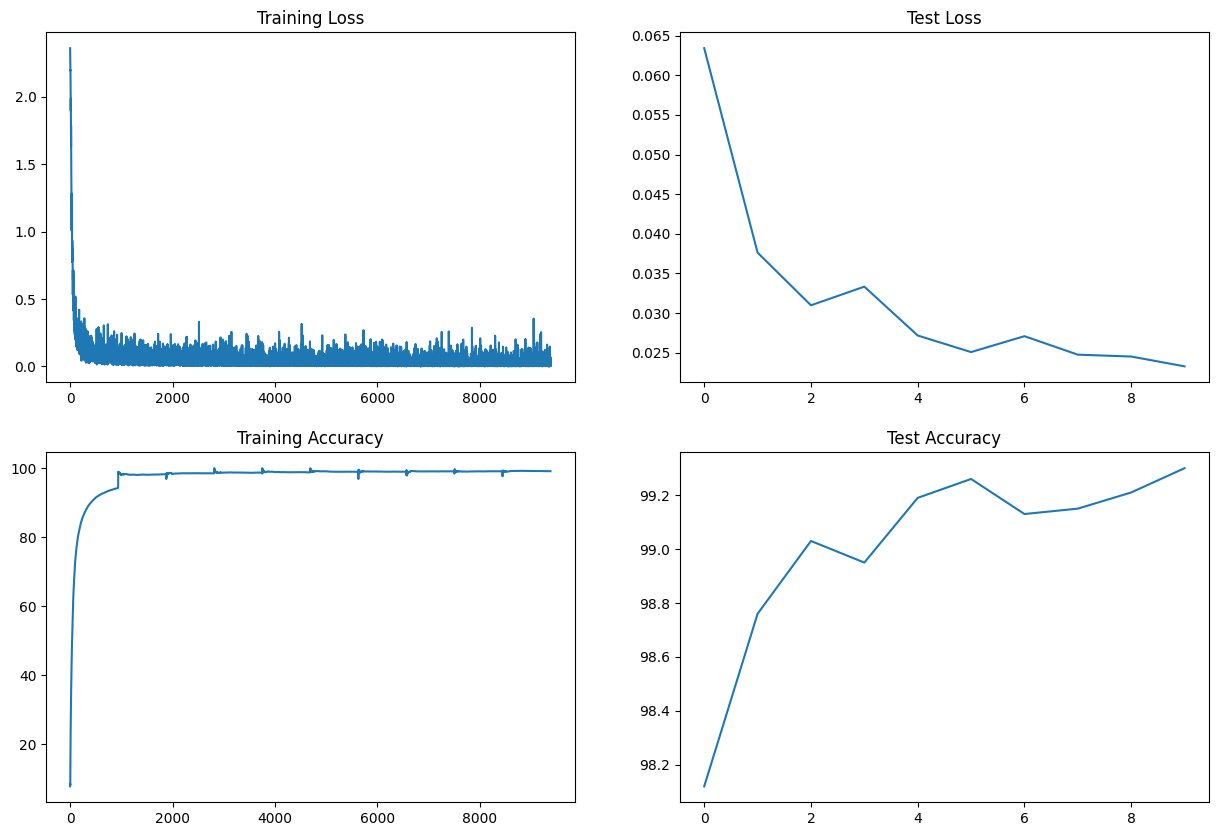

In [15]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
# axs[0, 0].plot(train_losses)
axs[0, 0].plot([t.cpu().item() for t in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")